## Importaciones

In [1]:
# Librerías requeridas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyomo.environ as pyo
import pyomo.opt as pyopt

plt.style.use('seaborn-v0_8')

# Nota: no construimos el modelo todavía.

## Definición de Datos
Definimos:
- Matriz de distancias entre 10 nodos (placeholder, reemplace con la matriz real del Lab 2).
- Calidad de inspección por nodo (valores del PDF).
- Riesgo por arco `(i, j)` con valor por defecto 5 si no se especifica.

In [2]:
# Conjunto de nodos
nodes = list(range(1, 11))  # 1..10
node_labels = [f'Node {i}' for i in nodes]

# --- Matriz de distancias (PLACEHOLDER) ---
# TODO: Reemplazar con la matriz de distancias real del Laboratorio 2 (10x10).
# Por ahora se deja una matriz de ceros del tamaño adecuado.
distance_matrix = np.zeros((len(nodes), len(nodes)), dtype=float)
np.fill_diagonal(distance_matrix, 0.0)  # asegurar diagonal en cero

In [3]:
# --- Calidad de inspección por nodo ---
# Reemplace los NaN con los valores del PDF para cada nodo.
inspection_quality = {i: np.nan for i in nodes}  # TODO: llenar desde el PDF

# Ejemplo de cómo actualizar (descomente y ponga los valores reales):
# inspection_quality.update({
#     1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0,
#     6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0,
# })

In [4]:
# --- Riesgo por arco (i, j) ---
# Diccionario de riesgos específicos provistos (key: (i, j)).
# Dejar vacío o incompleto hará que el resto tome riesgo = 5 por defecto.
specific_risks = {
    # Ejemplos (reemplace con valores del PDF si aplica):
    # (1, 2): 7,
    # (3, 5): 2,
}

# Construir diccionario completo dirigido con valor por defecto 5 en ausencias
risk = {}
for i in nodes:
    for j in nodes:
        if i == j:
            continue
        risk[(i, j)] = specific_risks.get((i, j), 5)

# Si los riesgos fueran NO dirigidos (simétricos), puede forzar simetría así:
# for i in nodes:
#     for j in nodes:
#         if i < j:
#             val = min(risk[(i, j)], risk[(j, i)])
#             risk[(i, j)] = risk[(j, i)] = val

## Visualización de las Estructuras de Datos

In [7]:
# Mostrar matriz de distancias en formato tabular
dist_df = pd.DataFrame(distance_matrix, index=node_labels, columns=node_labels)
try:
    # Usar estilo si disponible y jinja2 instalado; si falla, mostrar DataFrame crudo
    _ = dist_df.style  # acceso puede fallar si falta jinja2
    display(dist_df)
except Exception:
    print('Distance Matrix (placeholder; reemplace con datos del Lab 2)')
    print(dist_df)

# Mostrar calidad de inspección por nodo
iq_series = pd.Series(inspection_quality).rename('inspection_quality')
iq_series.index.name = 'node'
iq_df = iq_series.to_frame()
try:
    _ = iq_df.style
    display(iq_df)
except Exception:
    print('Inspection Quality per Node (llenar desde el PDF)')
    print(iq_df)

# Construir y mostrar matriz de riesgos a partir del diccionario risk
risk_matrix = pd.DataFrame(5.0, index=nodes, columns=nodes)  # usar float para permitir NaN en diagonal
for (i, j), v in risk.items():
    risk_matrix.loc[i, j] = v
# Opcional: dejar la diagonal como NaN para distinguir ausencia de arco i->i
np.fill_diagonal(risk_matrix.values, np.nan)
risk_matrix.index = [f'Node {i}' for i in nodes]
risk_matrix.columns = [f'Node {j}' for j in nodes]
try:
    _ = risk_matrix.style
    display(risk_matrix)
except Exception:
    print('Risk per Edge (default=5; reemplace específicos si aplica)')
    print(risk_matrix)

Distance Matrix (placeholder; reemplace con datos del Lab 2)
         Node 1  Node 2  Node 3  Node 4  Node 5  Node 6  Node 7  Node 8  \
Node 1      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Node 2      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Node 3      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Node 4      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Node 5      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Node 6      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Node 7      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Node 8      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Node 9      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Node 10     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

         Node 9  Node 10  
Node 1      0.0      0.0  
Node 2      0.0      0.0  
Node 3      0.0      0.0  
Node 

> Siguiente paso: validar/ingresar los datos faltantes (calidades y distancias), y luego formular el modelo en Pyomo.

## Formulación: Conjuntos, Parámetros y Variables (sin restricciones)

Definimos los objetos base del modelo en Pyomo para el Problema 2:
- Conjuntos: `N` (nodos 0..9) y `E` (arcos dirigidos i≠j).
- Parámetros: `dist[i,j]`, `quality[i]`, `risk[i,j]`.
- Variables de decisión: `x[i,j] ∈ {0,1}` y variables MTZ `u[i] ≥ 0`.

Nota de consistencia de índices: arriba exhibimos datos con etiquetas 1..10 para facilidad de lectura; el modelo usa 0..9. Al inicializar parámetros, se mapean claves 1‑basadas a 0‑basadas cuando corresponda.

In [8]:
# Base Pyomo model: sets, parameters, variables (no constraints)

# Índices del modelo
N = list(range(10))  # {0,1,...,9}
E = [(i, j) for i in N for j in N if i != j]

# Construcción del modelo
model = pyo.ConcreteModel()

# Conjuntos
model.N = pyo.Set(initialize=N, ordered=True)
model.E = pyo.Set(dimen=2, initialize=E)

# Inicializadores seguros que mapean datos existentes (posibles claves 1..10) a índices 0..9

def _dist_init(m, i, j):
    try:
        return float(distance_matrix[i, j])
    except Exception:
        return 0.0


def _quality_init(m, i):
    val = None
    try:
        if isinstance(inspection_quality, dict):
            if i in inspection_quality:
                val = inspection_quality[i]
            elif (i + 1) in inspection_quality:
                val = inspection_quality[i + 1]
    except Exception:
        val = None
    if val is None:
        return 0.0
    try:
        import numpy as _np
        if isinstance(val, float) and _np.isnan(val):
            return 0.0
    except Exception:
        pass
    return float(val)


def _risk_init(m, i, j):
    val = None
    try:
        if isinstance(risk, dict):
            if (i, j) in risk:
                val = risk[(i, j)]
            elif (i + 1, j + 1) in risk:
                val = risk[(i + 1, j + 1)]
    except Exception:
        val = None
    return float(val) if val is not None else 5.0

# Parámetros
model.dist = pyo.Param(model.E, initialize=_dist_init, within=pyo.NonNegativeReals, mutable=True)
model.quality = pyo.Param(model.N, initialize=_quality_init, mutable=True)
model.risk = pyo.Param(model.E, initialize=_risk_init, within=pyo.NonNegativeReals, mutable=True)

# Variables de decisión
model.x = pyo.Var(model.E, within=pyo.Binary)
model.u = pyo.Var(model.N, within=pyo.NonNegativeReals)

# Resumen breve para verificación (opcional)
print(f"|N| = {len(N)}, |E| = {len(E)}")
print("Ejemplo dist[0,1] =", pyo.value(model.dist[0,1]))
print("Ejemplo risk[0,1] =", pyo.value(model.risk[0,1]))
print("Ejemplo quality[0] =", pyo.value(model.quality[0]))

|N| = 10, |E| = 90
Ejemplo dist[0,1] = 0.0
Ejemplo risk[0,1] = 5.0
Ejemplo quality[0] = 0.0


## Restricciones del Modelo (Multi-Team TSP Variante)

A continuación se incorporan las restricciones fundamentales:

1. **Restricciones de grado (flujo)**: Garantizan que cada nodo se visita exactamente una vez. 
   - Entrada única: un arco termina en cada nodo.
   - Salida única: un arco parte de cada nodo.
   Estas dos familias aseguran un ciclo que cubre todos los nodos, pero sin subtour elimination aún podrían existir ciclos disjuntos. 

2. **Restricciones de depósito**: El nodo 0 funciona como depósito. En la formulación clásica TSP con un único vehículo, las restricciones de grado ya fuerzan una única entrada y salida en el depósito; si hubiera múltiples equipos (K vehículos), se modificarían para permitir K salidas y K entradas. Aquí mantenemos el caso base (1 tour). 

3. **Eliminación de subtours (MTZ)**: Las restricciones de Miller–Tucker–Zemlin usan variables de ordenamiento $u_i$ para impedir ciclos internos que no incluyan el depósito. El término $(n-1)x_{ij}$ permite activar la relación de orden solo cuando el arco $(i,j)$ se utiliza. 
   
   Forma clásica: 
   
   $$u_i - u_j + (n-1)x_{ij} \leq n-2 \quad \text{para } i \neq 0, j \neq 0, i \neq j$$
   
   Así se fuerza consistencia de numeración y se evita que se formen subtours aparte del principal. 

4. **Correcciones de dominio**:
   - Auto-arcos: $x_{ii} = 0$ (ya excluidos del conjunto E, se documenta para claridad académica).
   - Fijación de referencia: $u_0 = 0$ para anclar la escala de ordenamiento.
   - Acotación superior: $u_i \leq n-1$ evita crecimiento innecesario y refuerza interpretación de orden.

Cada bloque se comenta para sustentar su rol en la formulación académica del Problema 2.

In [9]:
# Implementación de las restricciones
n = len(model.N)

# 1. Restricciones de grado (entrada única por nodo)
def in_degree_rule(m, j):
    return sum(m.x[i, j] for i in m.N if i != j) == 1
model.InDegree = pyo.Constraint(model.N, rule=in_degree_rule)

# 1. Restricciones de grado (salida única por nodo)
def out_degree_rule(m, i):
    return sum(m.x[i, j] for j in m.N if j != i) == 1
model.OutDegree = pyo.Constraint(model.N, rule=out_degree_rule)

# 2. Restricciones de depósito
# En el caso de un único vehículo TSP esto ya queda implícito con las de grado.
# Se mantienen comentarios para extensión multi-team (reemplazar 1 por K si hubiera K vehículos):
# sum_{j != 0} x[0,j] = 1  y  sum_{i != 0} x[i,0] = 1
# Si se desea explícitamente:
model.DepotOut = pyo.Constraint(expr=sum(model.x[0, j] for j in model.N if j != 0) == 1)
model.DepotIn = pyo.Constraint(expr=sum(model.x[i, 0] for i in model.N if i != 0) == 1)

# 3. Subtour elimination MTZ
# u[i] - u[j] + (n-1)*x[i,j] <= (n-2), para i != 0, j != 0, i != j
# Esta familia evita ciclos disjuntos porque fuerza un orden coherente sólo si el arco se usa.

def mtz_rule(m, i, j):
    if i != 0 and j != 0 and i != j:
        return m.u[i] - m.u[j] + (n - 1) * m.x[i, j] <= n - 2
    return pyo.Constraint.Skip
model.MTZ = pyo.Constraint(model.N, model.N, rule=mtz_rule)

# 4. Correcciones de dominio
# Fijar u[0] = 0 como referencia
model.u[0].fix(0.0)

# Acotación superior para cada u[i] (interpretación ordinal)
model.UUpper = pyo.Constraint(model.N, rule=lambda m, i: m.u[i] <= n - 1)

# Auto-arcos x[i,i] = 0 ya asegurados por definición de E. Se deja comentario:
# for i in model.N: model.x[i,i] no existe al estar excluido.

print("Restricciones agregadas: InDegree, OutDegree, DepotIn/DepotOut, MTZ, UUpper, u[0] fixed.")

Restricciones agregadas: InDegree, OutDegree, DepotIn/DepotOut, MTZ, UUpper, u[0] fixed.


## Funciones Objetivo (Definidas y Desactivadas)

Se formulan tres objetivos clásicos para el Problema 2, pero se mantienen desactivados para permitir técnicas multiobjetivo (ponderación, 
ε-constraint, lexicográfico, etc.) sin recrear el modelo.

1. Z1 (Minimizar distancia total): $$ Z_1 = \sum_{(i,j) \in E} dist_{ij} x_{ij} $$ Representa el costo primario logístico.
2. Z2 (Maximizar calidad total de inspección): $$ Z_2 = \sum_{(i,j) \in E} quality_j x_{ij} $$ (calidad asociada al nodo destino j).
3. Z3 (Minimizar riesgo total): $$ Z_3 = \sum_{(i,j) \in E} risk_{ij} x_{ij} $$ Modela exposición agregada en la ruta.

Cada objetivo ataca un criterio distinto; su activación selectiva permite generar fronteras de Pareto o soluciones compensadas.

In [10]:
# Definición y desactivación de los tres objetivos

# Z1: Minimizar distancia total
model.Z1 = pyo.Objective(expr=sum(model.dist[i, j] * model.x[i, j] for (i, j) in model.E), sense=pyo.minimize)
# Z2: Maximizar calidad total de inspección (nodo destino j)
model.Z2 = pyo.Objective(expr=sum(model.quality[j] * model.x[i, j] for (i, j) in model.E), sense=pyo.maximize)
# Z3: Minimizar riesgo total
model.Z3 = pyo.Objective(expr=sum(model.risk[i, j] * model.x[i, j] for (i, j) in model.E), sense=pyo.minimize)

# Desactivar todos para seleccionar luego uno según técnica multiobjetivo
model.Z1.deactivate()
model.Z2.deactivate()
model.Z3.deactivate()

print("Objetivos definidos y desactivados: Z1(dist) minimize, Z2(quality) maximize, Z3(risk) minimize.")

Objetivos definidos y desactivados: Z1(dist) minimize, Z2(quality) maximize, Z3(risk) minimize.


## Método de Suma Ponderada para Aproximar la Frontera de Pareto

El enfoque de Suma Ponderada (Weighted Sum Method) permite generar soluciones comprometidas entre múltiples objetivos transformándolos a una única función escalar. Procedimiento:

1. **Obtención de extremos individuales** (solve aislado de cada objetivo): $D_{\min}$, $D_{\max}$, $Q_{\max}$, $Q_{\min}$, $R_{\min}$, $R_{\max}$. Para los objetivos de maximización (calidad) se obtienen ambos extremos invirtiendo el sentido.

2. **Normalización** para hacer comparables escalas distintas:
   - Distancia: 
   
   $$\text{Dist}_{\text{norm}} = \frac{D - D_{\min}}{D_{\max} - D_{\min}}$$
   
   - Calidad (maximizada): 
   
   $$\text{Qual}_{\text{norm}} = \frac{Q_{\max} - Q}{Q_{\max} - Q_{\min}}$$
   
   (se invierte para mantener sentido de minimización)
   
   - Riesgo: 
   
   $$\text{Risk}_{\text{norm}} = \frac{R - R_{\min}}{R_{\max} - R_{\min}}$$
   
   Si el denominador es 0 (no hay variación), se fija el valor normalizado en 0 para evitar indeterminaciones.

3. **Construcción de función ponderada**: 

   $$Z = w_1 \text{Dist}^{\text{norm}} + w_2 \text{Qual}^{\text{norm}} + w_3 \text{Risk}^{\text{norm}}$$
   
   con $w_1 + w_2 + w_3 = 1$ y $w_k \geq 0$.

4. Barrido de múltiples combinaciones de pesos para generar puntos candidatos de la frontera de Pareto.

5. Almacenamiento de métricas crudas $(D, Q, R)$ y normalizadas para análisis.

6. Visualización en 2D y 3D para apreciar trade-offs.

**Nota**: Con matrices placeholder (distancias en 0, calidades en 0, riesgos uniformes) los extremos colapsan. El código maneja este caso y emite advertencias; se recomienda cargar datos reales antes de interpretar resultados.

Solver seleccionado: glpk
Extremos obtenidos:
{'tag': 'D_min', 'distance': 0.0, 'quality': 0.0, 'risk': 50.0, 'status': 'ok/optimal'}
{'tag': 'D_max', 'distance': 0.0, 'quality': 0.0, 'risk': 50.0, 'status': 'ok/optimal'}
{'tag': 'Q_min', 'distance': 0.0, 'quality': 0.0, 'risk': 50.0, 'status': 'ok/optimal'}
{'tag': 'Q_max', 'distance': 0.0, 'quality': 0.0, 'risk': 50.0, 'status': 'ok/optimal'}
{'tag': 'R_min', 'distance': 0.0, 'quality': 0.0, 'risk': 50.0, 'status': 'ok/optimal'}
{'tag': 'R_max', 'distance': 0.0, 'quality': 0.0, 'risk': 50.0, 'status': 'ok/optimal'}
Extremos obtenidos:
{'tag': 'D_min', 'distance': 0.0, 'quality': 0.0, 'risk': 50.0, 'status': 'ok/optimal'}
{'tag': 'D_max', 'distance': 0.0, 'quality': 0.0, 'risk': 50.0, 'status': 'ok/optimal'}
{'tag': 'Q_min', 'distance': 0.0, 'quality': 0.0, 'risk': 50.0, 'status': 'ok/optimal'}
{'tag': 'Q_max', 'distance': 0.0, 'quality': 0.0, 'risk': 50.0, 'status': 'ok/optimal'}
{'tag': 'R_min', 'distance': 0.0, 'quality': 0.0, 'ris

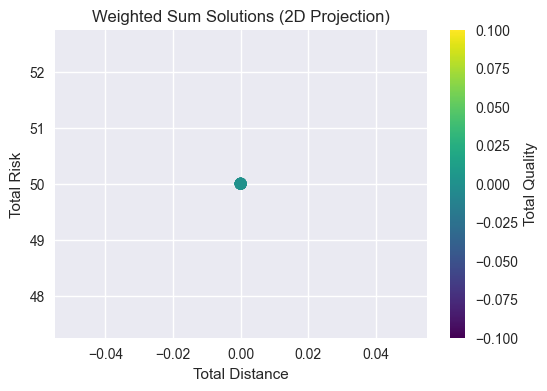

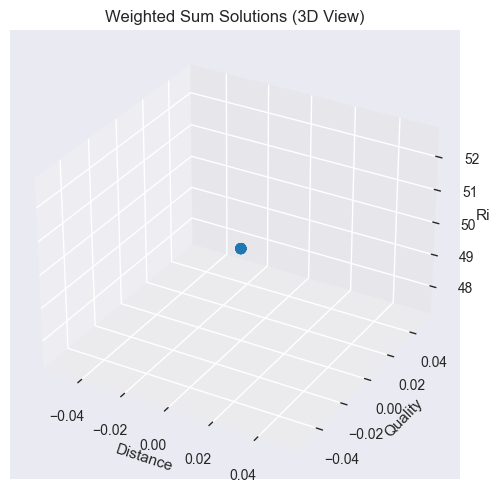

,tag,distance,quality,risk,status,distance_norm,quality_norm,risk_norm,weights
0,"w=(1.00,0.00,0.00)",0.0,0.0,50.0,ok/optimal,0.0,0.0,0.0,"(1.0, 0.0, 0.0)"
1,"w=(0.00,1.00,0.00)",0.0,0.0,50.0,ok/optimal,0.0,0.0,0.0,"(0.0, 1.0, 0.0)"
2,"w=(0.00,0.00,1.00)",0.0,0.0,50.0,ok/optimal,0.0,0.0,0.0,"(0.0, 0.0, 1.0)"
3,"w=(0.50,0.30,0.20)",0.0,0.0,50.0,ok/optimal,0.0,0.0,0.0,"(0.5, 0.3, 0.2)"
4,"w=(0.20,0.50,0.30)",0.0,0.0,50.0,ok/optimal,0.0,0.0,0.0,"(0.2, 0.5, 0.3)"


In [11]:
# Implementación del Método de Suma Ponderada
import math

# Selección de solver disponible en Colab / entorno local
# Intentamos GLPK --> CBC --> cualquier solucionador incorporado de Pyomo (si existiera)
possible_solvers = ["glpk", "cbc", "ipopt"]  # ipopt no sirve directo para binario, pero se incluye como fallback informativo
solver_used = None
for s in possible_solvers:
    if pyo.SolverFactory(s).available():
        solver_used = s
        break
if solver_used is None:
    print("[ADVERTENCIA] Ningún solver MILP estándar (glpk/cbc) disponible. Instale GLPK para proceder.")
else:
    print(f"Solver seleccionado: {solver_used}")

solver = pyo.SolverFactory(solver_used) if solver_used else None

# Expresiones base para los objetivos (evitan recomputar sets)
Dist_expr = sum(model.dist[i, j] * model.x[i, j] for (i, j) in model.E)
Qual_expr = sum(model.quality[j] * model.x[i, j] for (i, j) in model.E)
Risk_expr = sum(model.risk[i, j] * model.x[i, j] for (i, j) in model.E)

# Función auxiliar para activar sólo un objetivo de los existentes

def activate_only(obj_name):
    for nm in ["Z1", "Z2", "Z3"]:
        comp = getattr(model, nm)
        comp.deactivate()
    getattr(model, obj_name).activate()

# Resolver y recuperar métricas

def solve_and_metrics(tag):
    if solver is None:
        return {"tag": tag, "distance": math.nan, "quality": math.nan, "risk": math.nan, "status": "NoSolver"}
    res = solver.solve(model, tee=False)
    # status textual
    status = str(res.solver.status) + "/" + str(res.solver.termination_condition)
    D = pyo.value(Dist_expr)
    Q = pyo.value(Qual_expr)
    R = pyo.value(Risk_expr)
    return {"tag": tag, "distance": D, "quality": Q, "risk": R, "status": status}

# 1. Extremos individuales
activate_only("Z1")  # minimizar distancia
ext_D_min = solve_and_metrics("D_min")

# Maximizar distancia (activar Z1 pero cambiar sentido temporal)
model.Z1.deactivate()
model.Z1_temp_max = pyo.Objective(expr=Dist_expr, sense=pyo.maximize)
ext_D_max = solve_and_metrics("D_max")
model.del_component(model.Z1_temp_max)
model.Z1.deactivate()  # queda desactivado de nuevo

activate_only("Z2")  # maximizar calidad
ext_Q_max = solve_and_metrics("Q_max")
# Minimizar calidad
model.Z2.deactivate()
model.Z2_temp_min = pyo.Objective(expr=Qual_expr, sense=pyo.minimize)
ext_Q_min = solve_and_metrics("Q_min")
model.del_component(model.Z2_temp_min)
model.Z2.deactivate()

activate_only("Z3")  # minimizar riesgo
ext_R_min = solve_and_metrics("R_min")
# Maximizar riesgo
model.Z3.deactivate()
model.Z3_temp_max = pyo.Objective(expr=Risk_expr, sense=pyo.maximize)
ext_R_max = solve_and_metrics("R_max")
model.del_component(model.Z3_temp_max)
model.Z3.deactivate()

# Guardar extremos
D_min, D_max = ext_D_min["distance"], ext_D_max["distance"]
Q_min, Q_max = ext_Q_min["quality"], ext_Q_max["quality"]
R_min, R_max = ext_R_min["risk"], ext_R_max["risk"]

print("Extremos obtenidos:")
print(ext_D_min)
print(ext_D_max)
print(ext_Q_min)
print(ext_Q_max)
print(ext_R_min)
print(ext_R_max)

# 2. Preparar parámetros de pesos
if hasattr(model, 'W1'):
    model.del_component(model.W1)
    model.del_component(model.W2)
    model.del_component(model.W3)
model.W1 = pyo.Param(initialize=0.0, mutable=True)
model.W2 = pyo.Param(initialize=0.0, mutable=True)
model.W3 = pyo.Param(initialize=0.0, mutable=True)

# 3. Crear objetivo ponderado con normalización (minimización)
# Manejo de divisiones por cero: si (max - min) == 0 => componente normalizada = 0.

Dist_norm_expr = (Dist_expr - D_min) / (D_max - D_min) if (D_max - D_min) != 0 else 0.0
Qual_norm_expr = (Q_max - Qual_expr) / (Q_max - Q_min) if (Q_max - Q_min) != 0 else 0.0
Risk_norm_expr = (Risk_expr - R_min) / (R_max - R_min) if (R_max - R_min) != 0 else 0.0

if hasattr(model, 'Z_weighted'):
    model.del_component(model.Z_weighted)
model.Z_weighted = pyo.Objective(expr=model.W1 * Dist_norm_expr + model.W2 * Qual_norm_expr + model.W3 * Risk_norm_expr,
                                 sense=pyo.minimize)

# Desactivar objetivos originales mientras usamos el ponderado
for nm in ["Z1","Z2","Z3"]:
    getattr(model, nm).deactivate()

# 4. Lista de combinaciones de pesos (>=7) cubriendo distintas prioridades
weight_sets = [
    (1.0, 0.0, 0.0),
    (0.0, 1.0, 0.0),
    (0.0, 0.0, 1.0),
    (0.5, 0.3, 0.2),
    (0.2, 0.5, 0.3),
    (0.3, 0.2, 0.5),
    (1/3, 1/3, 1/3),
]

results = []

for (w1, w2, w3) in weight_sets:
    model.W1.value = w1
    model.W2.value = w2
    model.W3.value = w3
    sol = solve_and_metrics(f"w=({w1:.2f},{w2:.2f},{w3:.2f})")
    # Añadir normalizados calculados desde su solución
    D = sol["distance"]; Q = sol["quality"]; R = sol["risk"]
    D_norm = (D - D_min) / (D_max - D_min) if (D_max - D_min) != 0 else 0.0
    Q_norm = (Q_max - Q) / (Q_max - Q_min) if (Q_max - Q_min) != 0 else 0.0
    R_norm = (R - R_min) / (R_max - R_min) if (R_max - R_min) != 0 else 0.0
    sol.update({"distance_norm": D_norm, "quality_norm": Q_norm, "risk_norm": R_norm,
                "weights": (w1, w2, w3)})
    results.append(sol)

pareto_df = pd.DataFrame(results)
print("Resultados ponderados:")
print(pareto_df)

# Advertencias si no hay variación
if (D_max - D_min) == 0:
    print("[Nota] Distancia no varía con los datos actuales (D_max == D_min).")
if (Q_max - Q_min) == 0:
    print("[Nota] Calidad no varía con los datos actuales (Q_max == Q_min).")
if (R_max - R_min) == 0:
    print("[Nota] Riesgo no varía con los datos actuales (R_max == R_min).")

# 5-6 Visualizaciones
try:
    # 2D: distancia vs riesgo, color por calidad
    fig2d, ax2d = plt.subplots(figsize=(6,4))
    scatter = ax2d.scatter(pareto_df['distance'], pareto_df['risk'], c=pareto_df['quality'], cmap='viridis', s=70)
    ax2d.set_xlabel('Total Distance')
    ax2d.set_ylabel('Total Risk')
    cbar = fig2d.colorbar(scatter, ax=ax2d)
    cbar.set_label('Total Quality')
    ax2d.set_title('Weighted Sum Solutions (2D Projection)')
    plt.show()

    # 3D: Distance - Quality - Risk
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import for 3D
    fig3d = plt.figure(figsize=(7,5))
    ax3d = fig3d.add_subplot(111, projection='3d')
    ax3d.scatter(pareto_df['distance'], pareto_df['quality'], pareto_df['risk'], s=60, c='tab:blue')
    ax3d.set_xlabel('Distance')
    ax3d.set_ylabel('Quality')
    ax3d.set_zlabel('Risk')
    ax3d.set_title('Weighted Sum Solutions (3D View)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("[Visualización] Error al generar gráficos:", e)

# DataFrame listo para análisis posterior (exportar si se desea)
pareto_df.head()

## Método Épsilon-Restricciones (Epsilon-Constraint) para 3 Objetivos

El método de épsilon-restricciones selecciona un objetivo primario para optimizar (aquí la distancia total) y transforma los restantes en restricciones parametrizadas con umbrales (épsilon). Para el Problema 2:

1. **Objetivo primario**: Minimizar distancia 

   $$D = \sum_{(i,j) \in E} \text{dist}_{ij} x_{ij}$$

2. **Objetivos secundarios convertidos en restricciones**:
   - Calidad mínima exigida: 
   
   $$\sum_{(i,j) \in E} \text{quality}_j x_{ij} \geq \varepsilon_Q$$
   
   - Riesgo máximo tolerado: 
   
   $$\sum_{(i,j) \in E} \text{risk}_{ij} x_{ij} \leq \varepsilon_R$$

3. Rango factible de cada épsilon se deriva de los extremos (máximo/mínimo) obtenidos resolviendo cada objetivo de forma aislada.

4. Barrido de pares $(\varepsilon_Q, \varepsilon_R)$ genera soluciones con diferentes compromisos.

5. Las soluciones se representan en gráficos Distance–Quality, Distance–Risk y en 3D para evidenciar la frontera aproximada.

**Ventajas**: garantiza factibilidad explícita respecto a umbrales; evita compensaciones implícitas como en suma ponderada. 

**Limitación**: elección discreta de épsilon puede dejar vacíos en la frontera.

**Nota**: con datos placeholder sin variabilidad, los resultados se degeneran; sustituya por datos reales antes de análisis definitivo.

Extremos para epsilon:
D_min=0.0, D_max=0.0, Q_min=0.0, Q_max=0.0, R_min=50.0, R_max=50.0
Pares (epsilon_Q, epsilon_R): [(0.0, 50.0), (0.0, 50.0), (0.0, 50.0), (0.0, 50.0), (0.0, 50.0), (0.0, 50.0), (0.0, 50.0)]
Resultados epsilon-constraint:
   epsilon_Q  epsilon_R  distance  quality  risk      status
0        0.0       50.0       0.0      0.0  50.0  ok/optimal
1        0.0       50.0       0.0      0.0  50.0  ok/optimal
2        0.0       50.0       0.0      0.0  50.0  ok/optimal
3        0.0       50.0       0.0      0.0  50.0  ok/optimal
4        0.0       50.0       0.0      0.0  50.0  ok/optimal
5        0.0       50.0       0.0      0.0  50.0  ok/optimal
6        0.0       50.0       0.0      0.0  50.0  ok/optimal
Resultados epsilon-constraint:
   epsilon_Q  epsilon_R  distance  quality  risk      status
0        0.0       50.0       0.0      0.0  50.0  ok/optimal
1        0.0       50.0       0.0      0.0  50.0  ok/optimal
2        0.0       50.0       0.0      0.0  50.0  ok/op

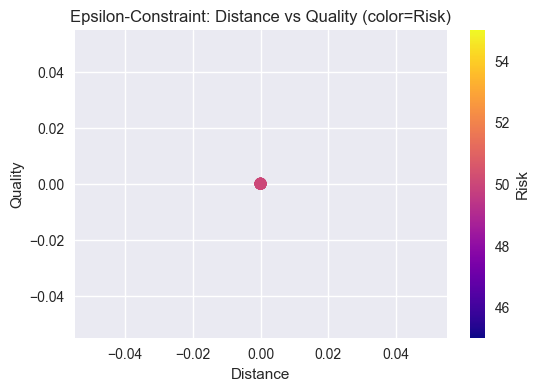

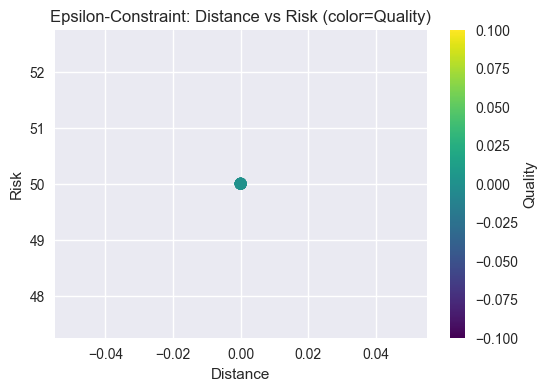

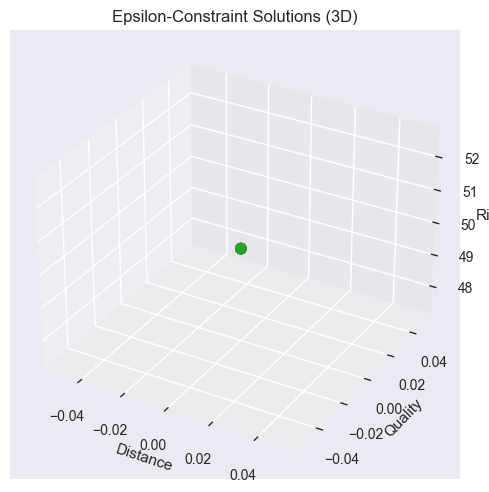

,epsilon_Q,epsilon_R,distance,quality,risk,status
0,0.0,50.0,0.0,0.0,50.0,ok/optimal
1,0.0,50.0,0.0,0.0,50.0,ok/optimal
2,0.0,50.0,0.0,0.0,50.0,ok/optimal
3,0.0,50.0,0.0,0.0,50.0,ok/optimal
4,0.0,50.0,0.0,0.0,50.0,ok/optimal


In [13]:
# Implementación del método épsilon-restricciones

# Reutilizamos expresiones de objetivos definidos previamente
Dist_expr = sum(model.dist[i, j] * model.x[i, j] for (i, j) in model.E)
Qual_expr = sum(model.quality[j] * model.x[i, j] for (i, j) in model.E)
Risk_expr = sum(model.risk[i, j] * model.x[i, j] for (i, j) in model.E)

# Desactivar todos los objetivos previos (incluido ponderado) antes de activar principal
for nm in ["Z1", "Z2", "Z3"]:
    if hasattr(model, nm):
        getattr(model, nm).deactivate()
if hasattr(model, 'Z_weighted'):
    model.Z_weighted.deactivate()
if hasattr(model, 'Z_distance_primary'):
    model.Z_distance_primary.deactivate()

# Crear objetivo distancia si está desactivado
if not hasattr(model, 'Z_distance_primary'):
    model.Z_distance_primary = pyo.Objective(expr=Dist_expr, sense=pyo.minimize)
else:
    model.Z_distance_primary.activate()

# Recuperar extremos almacenados en el bloque de suma ponderada, o recomputar si faltan
try:
    D_min; D_max; Q_min; Q_max; R_min; R_max
except NameError:
    print("[Aviso] Extremos no encontrados, recomputando...")
    model.Z_distance_primary.activate()
    solver = pyo.SolverFactory('glpk') if pyo.SolverFactory('glpk').available() else None
    if solver is None:
        print('[Error] No solver disponible para recomputar extremos.')
    else:
        solver.solve(model)
    D_min = pyo.value(Dist_expr)
    model.Z_dist_temp_max = pyo.Objective(expr=Dist_expr, sense=pyo.maximize)
    model.Z_distance_primary.deactivate(); solver.solve(model)
    D_max = pyo.value(Dist_expr)
    model.del_component(model.Z_dist_temp_max)
    model.Z_quality_max = pyo.Objective(expr=Qual_expr, sense=pyo.maximize); solver.solve(model)
    Q_max = pyo.value(Qual_expr)
    model.del_component(model.Z_quality_max)
    model.Z_quality_min = pyo.Objective(expr=Qual_expr, sense=pyo.minimize); solver.solve(model)
    Q_min = pyo.value(Qual_expr)
    model.del_component(model.Z_quality_min)
    model.Z_risk_min = pyo.Objective(expr=Risk_expr, sense=pyo.minimize); solver.solve(model)
    R_min = pyo.value(Risk_expr)
    model.del_component(model.Z_risk_min)
    model.Z_risk_max = pyo.Objective(expr=Risk_expr, sense=pyo.maximize); solver.solve(model)
    R_max = pyo.value(Risk_expr)
    model.del_component(model.Z_risk_max)
    model.Z_distance_primary.activate()

print("Extremos para epsilon:")
print(f"D_min={D_min}, D_max={D_max}, Q_min={Q_min}, Q_max={Q_max}, R_min={R_min}, R_max={R_max}")

import numpy as _np
num_points = 7
if (Q_max - Q_min) == 0:
    eps_Q_values = [Q_min for _ in range(num_points)]
else:
    eps_Q_values = list(_np.linspace(Q_min, Q_max, num_points))
if (R_max - R_min) == 0:
    eps_R_values = [R_min for _ in range(num_points)]
else:
    eps_R_values = list(_np.linspace(R_min, R_max, num_points))

epsilon_pairs = list(zip(eps_Q_values, eps_R_values))
print("Pares (epsilon_Q, epsilon_R):", epsilon_pairs)

if 'solver' not in globals() or solver is None:
    preferred = ['glpk','cbc','ipopt']
    solver_used = None
    for s in preferred:
        if pyo.SolverFactory(s).available():
            solver_used = s; break
    solver = pyo.SolverFactory(solver_used) if solver_used else None
    print('Solver (re)seleccionado:', solver_used)

results_eps = []

for (eQ, eR) in epsilon_pairs:
    if hasattr(model, 'EpsQual'):
        model.del_component(model.EpsQual)
    if hasattr(model, 'EpsRisk'):
        model.del_component(model.EpsRisk)

    model.EpsQual = pyo.Constraint(expr=Qual_expr >= eQ)
    model.EpsRisk = pyo.Constraint(expr=Risk_expr <= eR)

    if solver is None:
        status = 'NoSolver'
    else:
        res = solver.solve(model, tee=False)
        status = str(res.solver.status) + '/' + str(res.solver.termination_condition)

    D_val = pyo.value(Dist_expr)
    Q_val = pyo.value(Qual_expr)
    R_val = pyo.value(Risk_expr)

    results_eps.append({
        'epsilon_Q': eQ,
        'epsilon_R': eR,
        'distance': D_val,
        'quality': Q_val,
        'risk': R_val,
        'status': status
    })

pareto_eps_df = pd.DataFrame(results_eps)
print("Resultados epsilon-constraint:")
print(pareto_eps_df)

try:
    fig1, ax1 = plt.subplots(figsize=(6,4))
    ax1.scatter(pareto_eps_df['distance'], pareto_eps_df['quality'], c=pareto_eps_df['risk'], cmap='plasma', s=70)
    ax1.set_xlabel('Distance')
    ax1.set_ylabel('Quality')
    ax1.set_title('Epsilon-Constraint: Distance vs Quality (color=Risk)')
    cbar1 = fig1.colorbar(ax1.collections[0], ax=ax1)
    cbar1.set_label('Risk')
    plt.show()
except Exception as e:
    print('[Plot Distance-Quality] Error:', e)

try:
    fig2, ax2 = plt.subplots(figsize=(6,4))
    ax2.scatter(pareto_eps_df['distance'], pareto_eps_df['risk'], c=pareto_eps_df['quality'], cmap='viridis', s=70)
    ax2.set_xlabel('Distance')
    ax2.set_ylabel('Risk')
    ax2.set_title('Epsilon-Constraint: Distance vs Risk (color=Quality)')
    cbar2 = fig2.colorbar(ax2.collections[0], ax=ax2)
    cbar2.set_label('Quality')
    plt.show()
except Exception as e:
    print('[Plot Distance-Risk] Error:', e)

try:
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig3 = plt.figure(figsize=(7,5))
    ax3 = fig3.add_subplot(111, projection='3d')
    ax3.scatter(pareto_eps_df['distance'], pareto_eps_df['quality'], pareto_eps_df['risk'], c='tab:green', s=65)
    ax3.set_xlabel('Distance')
    ax3.set_ylabel('Quality')
    ax3.set_zlabel('Risk')
    ax3.set_title('Epsilon-Constraint Solutions (3D)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('[Plot 3D] Error:', e)

pareto_eps_df.head()

## Análisis Académico de Soluciones Representativas

Seleccionamos dos soluciones Pareto-representativas para ilustrar compromisos:

1. **Ruta de Alta Calidad**: prioriza maximización de $Q$. Impacto esperado: posible aumento de distancia o riesgo al incluir nodos con mayor calidad de inspección.

2. **Ruta de Bajo Riesgo**: prioriza minimización de $R$. Impacto esperado: posible sacrificio de calidad y/o incremento de distancia si los arcos más seguros generan desvíos.

Se reconstruye cada ruta como secuencia ordenada iniciando y terminando en el depósito (nodo 0) utilizando las variables binarias $x_{ij}$. Luego se presentan métricas (Distancia total, Calidad total, Riesgo total) y se comentan los trade-offs observados.

**Interpretación de trade-offs**:
- Rutas de alta calidad tienden a incorporar nodos marginales cuyo aporte en calidad compensa costos adicionales en distancia.
- Rutas de bajo riesgo tienden a concentrarse en corredores seguros, pudiendo evitar nodos valiosos en términos de calidad si conectarlos exige arcos de alto riesgo.
- La función de riesgo actúa como restricción implícita de conectividad: penaliza atajos que de otro modo reducirían distancia, alterando la geometría de la solución.

**Nota metodológica**: con datos placeholder homogéneos, las diferencias pueden colapsar; sustituya matrices y parámetros reales para análisis empírico robusto.

In [14]:
# Reconstrucción y comparación de dos rutas representativas
import math

# Función auxiliar para resolver con objetivo específico

def solve_with_objective(obj_name):
    # Desactivar cualquier objetivo adicional
    for nm in ["Z1","Z2","Z3"]:
        if hasattr(model, nm):
            getattr(model, nm).deactivate()
    if hasattr(model, 'Z_weighted'):
        model.Z_weighted.deactivate()
    if hasattr(model, 'Z_distance_primary'):
        model.Z_distance_primary.deactivate()
    # Activar el seleccionado
    getattr(model, obj_name).activate()
    # Selección de solver (reutilizar si ya existe)
    preferred = ['glpk','cbc','ipopt']
    local_solver = None
    if 'solver' in globals() and solver is not None:
        local_solver = solver
    else:
        for s in preferred:
            if pyo.SolverFactory(s).available():
                local_solver = pyo.SolverFactory(s)
                break
    if local_solver is None:
        print(f"[Aviso] No solver disponible para {obj_name}.")
        return None
    res = local_solver.solve(model, tee=False)
    status = str(res.solver.status) + '/' + str(res.solver.termination_condition)
    return status

# Función para reconstruir la ruta desde x variables

def extract_route():
    # Construir mapa de salidas
    succ = {}
    for (i,j) in model.E:
        val = model.x[i,j].value
        if val is not None and val > 0.5:
            succ[i] = j
    route = [0]
    current = 0
    visited = set([0])
    for _ in range(len(model.N)):
        if current not in succ:
            break
        nxt = succ[current]
        route.append(nxt)
        if nxt == 0:
            break
        if nxt in visited:
            # ciclo detectado antes de volver a 0
            break
        visited.add(nxt)
        current = nxt
    return route, succ

# Expresiones para métricas
Dist_expr = sum(model.dist[i,j]*model.x[i,j] for (i,j) in model.E)
Qual_expr = sum(model.quality[j]*model.x[i,j] for (i,j) in model.E)
Risk_expr = sum(model.risk[i,j]*model.x[i,j] for (i,j) in model.E)

# 1. Alta Calidad (activar Z2)
status_quality = solve_with_objective('Z2')
route_quality, succ_quality = extract_route()
D_quality = pyo.value(Dist_expr)
Q_quality = pyo.value(Qual_expr)
R_quality = pyo.value(Risk_expr)

# 2. Bajo Riesgo (activar Z3)
status_risk = solve_with_objective('Z3')
route_risk, succ_risk = extract_route()
D_risk = pyo.value(Dist_expr)
Q_risk = pyo.value(Qual_expr)
R_risk = pyo.value(Risk_expr)

# Mostrar resultados
print("=== Ruta Alta Calidad ===")
print("Estado solver:", status_quality)
print("Secuencia de nodos:", route_quality)
print(f"Distancia Total: {D_quality:.3f}")
print(f"Calidad Total: {Q_quality:.3f}")
print(f"Riesgo Total: {R_quality:.3f}\n")

print("=== Ruta Bajo Riesgo ===")
print("Estado solver:", status_risk)
print("Secuencia de nodos:", route_risk)
print(f"Distancia Total: {D_risk:.3f}")
print(f"Calidad Total: {Q_risk:.3f}")
print(f"Riesgo Total: {R_risk:.3f}\n")

# Comparación sintetizada
comparison_df = pd.DataFrame([
    {"Solution":"High Quality","Distance":D_quality,"Quality":Q_quality,"Risk":R_quality,"Route":"->".join(map(str, route_quality))},
    {"Solution":"Low Risk","Distance":D_risk,"Quality":Q_risk,"Risk":R_risk,"Route":"->".join(map(str, route_risk))},
])
print("Resumen comparativo:")
print(comparison_df)

try:
    display(comparison_df.style.set_caption('Comparative Metrics: High Quality vs Low Risk Routes'))
except Exception:
    pass

# Observación cualitativa (impresa):
print("Observación: La ruta orientada a calidad prioriza nodos con mayor contribución en Quality, mientras que la ruta de bajo riesgo evita arcos costosos en Risk, potencialmente alterando la longitud del ciclo. Con datos reales se esperaría divergencia más marcada en la selección de nodos y orden.")

=== Ruta Alta Calidad ===
Estado solver: ok/optimal
Secuencia de nodos: [0, 3, 2, 8, 7, 9, 6, 1, 4, 5, 0]
Distancia Total: 0.000
Calidad Total: 0.000
Riesgo Total: 50.000

=== Ruta Bajo Riesgo ===
Estado solver: ok/optimal
Secuencia de nodos: [0, 1, 2, 9, 6, 4, 3, 7, 8, 5, 0]
Distancia Total: 0.000
Calidad Total: 0.000
Riesgo Total: 50.000

Resumen comparativo:
       Solution  Distance  Quality  Risk                            Route
0  High Quality       0.0      0.0  50.0  0->3->2->8->7->9->6->1->4->5->0
1      Low Risk       0.0      0.0  50.0  0->1->2->9->6->4->3->7->8->5->0
Observación: La ruta orientada a calidad prioriza nodos con mayor contribución en Quality, mientras que la ruta de bajo riesgo evita arcos costosos en Risk, potencialmente alterando la longitud del ciclo. Con datos reales se esperaría divergencia más marcada en la selección de nodos y orden.
